# Tip-to-Tip distance

Distance (number of edges/branches) connecting a pair of tips (`use_length = False`)

In [1]:
import numpy as np
from skbio import TreeNode
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine, correlation
import seaborn as sns
import scipy as sp

In [2]:
plt.rcParams.update({
    'figure.autolayout': True,
    'savefig.bbox': 'tight',
    'svg.fonttype': 'none',
    'font.sans-serif': 'Arial',
    'font.size': 12,
    'boxplot.medianprops.linewidth': 2,
    'boxplot.flierprops.markeredgecolor': 'none',
    'boxplot.flierprops.markersize': 5})

Load data

In [3]:
def loadMarkersPerGenome(fIn):
    markers_per_genome = {}
    with open(fIn, 'r') as f:
        for line in f:
            l = line.strip().split(':')
            markers_per_genome[l[0]] = int(l[1])
    return markers_per_genome

In [4]:
genomes = np.loadtxt(f'./input_data/genomes_sampled_family_10.txt', dtype = str)
genomes.shape

(1510,)

### WoL2: reference tree. Available from [WoL2 FTP server](http://ftp.microbio.me/pub/wol2/phylogeny/)

In [5]:
tree_wol = TreeNode.read(f'./input_data/tree.nwk')

In [6]:
tree_wol.shear(genomes, inplace = True)

Load inferred species trees

In [7]:
version = 2

KEGG

In [8]:
ks = [10, 50, 100, 200, 400, 600, 800, 1000]
ps = [0]
matrix = 'presence_absence_copies'
threshold = 1.0

In [9]:
%%time
trees_kegg_no_min = {}
for k in ks:
    for p in ps:
        combination = f'k_{k}_p_{p}/{matrix}' 
        dataPathIn = f'./input_data/wol2/kegg/bit_score_threshold_{threshold}/no_min_marker_genes_per_genome/{combination}'
        trees_kegg_no_min[f'k_{k}_p_{p}'] = TreeNode.read(f'{dataPathIn}/nid_astral-pro{version}.nwk')

CPU times: user 152 ms, sys: 5.21 ms, total: 158 ms
Wall time: 163 ms


In [10]:
dataPathIn = f'../markers_selection/output_data/wol2/marker_genes/kegg/bit_score_threshold_1.0'
markers_per_genome_kegg = {}
for k in ks:
    for p in ps:
        markers_per_genome_kegg[f'k_{k}_p_{p}'] = loadMarkersPerGenome(f'{dataPathIn}/num_markers_per_genome_k_{k}_p_{p}.txt')

EggNog

In [11]:
%%time
trees_eggnog_no_min = {}
for k in ks:
    for p in ps:
        combination = f'k_{k}_p_{p}/{matrix}' 
        dataPathIn = f'./input_data/wol2/eggnog/bit_score_threshold_{threshold}/no_min_marker_genes_per_genome/{combination}'
        trees_eggnog_no_min[f'k_{k}_p_{p}'] = TreeNode.read(f'{dataPathIn}/nid_astral-pro{version}.nwk')

CPU times: user 157 ms, sys: 7.45 ms, total: 164 ms
Wall time: 168 ms


In [12]:
dataPathIn = f'../markers_selection/output_data/wol2/marker_genes/eggnog/bit_score_threshold_1.0'
markers_per_genome_eggnog = {}
for k in ks:
    for p in ps:
        markers_per_genome_eggnog[f'k_{k}_p_{p}'] = loadMarkersPerGenome(f'{dataPathIn}/num_markers_per_genome_k_{k}_p_{p}.txt')

Phylophlan

In [13]:
dataPathIn = f'./input_data/wol2/phylophlan/wol2_min_marker_genes_per_genome_1'
tree_phylophlan_no_min = TreeNode.read(f'{dataPathIn}/nid_astral-pro{version}.nwk')

In [14]:
dataPathIn = f'../previous_marker_sets/phylophlan/wol2'
markers_per_genome_phylophlan = loadMarkersPerGenome(f'{dataPathIn}/markers_per_genome.txt')

## Calculate tip-to-tip distances

In [15]:
dm_wol = tree_wol.tip_tip_distances(use_length = False, endpoints = genomes.tolist())
dm_wol.shape

(1510, 1510)

Varying `k`

In [16]:
ks = [200, 400, 600, 800, 1000]

In [17]:
# dm_kegg_k_grid = []
distances_kegg_k_grid = {}
for k in ks:
    genomes = [genome for genome, num in markers_per_genome_kegg[f'k_{k}_p_{p}'].items() if num > 0]
    dm_tmp = trees_kegg_no_min[f'k_{k}_p_{p}'].tip_tip_distances(use_length = False,
                                        endpoints = genomes)
    dm_kegg_best = trees_kegg_no_min[f'k_1000_p_{p}'].tip_tip_distances(use_length = False, endpoints = genomes)
    distances_tmp = [cosine(dm_wol.data[i], dm_tmp.data[i]) for i in range(len(genomes))]
    # dm_kegg_k_grid.append(dm_tmp)
    distances_kegg_k_grid[k] = distances_tmp

In [18]:
# dm_kegg_k_grid = []
distances_eggnog_k_grid = {}
for k in ks:
    genomes = [genome for genome, num in markers_per_genome_eggnog[f'k_{k}_p_{p}'].items() if num > 0]
    dm_tmp = trees_eggnog_no_min[f'k_{k}_p_{p}'].tip_tip_distances(use_length = False,
                                        endpoints = genomes)
    dm_eggnog_best = trees_eggnog_no_min[f'k_1000_p_{p}'].tip_tip_distances(use_length = False, endpoints = genomes)
    distances_tmp = [cosine(dm_wol.data[i], dm_tmp.data[i]) for i in range(len(genomes))]
    # dm_kegg_k_grid.append(dm_tmp)
    distances_eggnog_k_grid[k] = distances_tmp

In [19]:
genomes = [genome for genome, num in markers_per_genome_phylophlan.items() if num > 0]
dm_tmp = tree_phylophlan_no_min.tip_tip_distances(use_length = False,
                                        endpoints = genomes)
distances_phylophlan = [cosine(dm_wol.data[i], dm_tmp.data[i]) for i in range(len(genomes))]

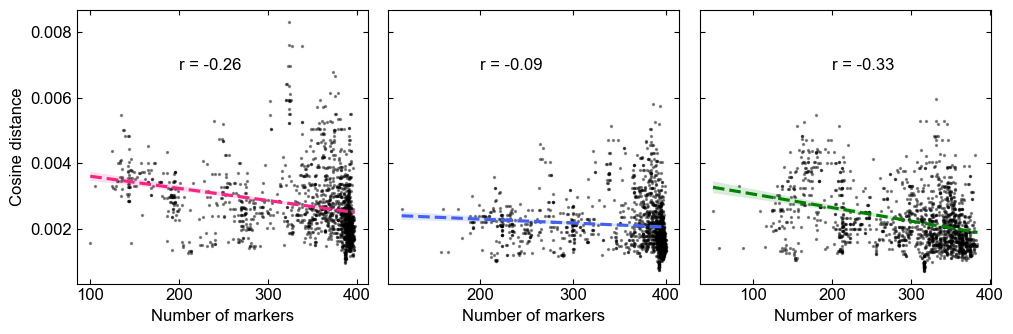

In [21]:
k, p = 400, 0
fig, axs = plt.subplots(1, 3, figsize = (10.3, 3.5), sharey = True)
# Kegg
x_kegg = [val for val in markers_per_genome_kegg[f'k_{k}_p_{p}'].values() if val > 0]
sns.regplot(ax = axs[0], x = x_kegg, y = distances_kegg_k_grid[k], 
            line_kws = {'color':'#f72585' , 'ls' : 'dashed'}, scatter_kws = {'alpha' : 0.4, 's' : 2, 'color' : 'k'})
slope_kegg, intercept_kegg, r_kegg, p_kegg, sterr_kegg = sp.stats.linregress(x_kegg, distances_kegg_k_grid[k])
axs[0].text(k/2, 0.007, 
            f'r = {r_kegg:.2f}',
            ha = 'left', va = 'center')

# Eggnog
x_eggnog = [val for val in markers_per_genome_eggnog[f'k_{k}_p_{p}'].values() if val > 0]
sns.regplot(ax = axs[1], x = x_eggnog, y = distances_eggnog_k_grid[k], 
            line_kws = {'color':'#4361ee', 'ls' : 'dashed'}, scatter_kws = {'alpha' : 0.4, 's' : 2, 'color' : 'k'})
slope_eggnog, intercept_eggnog, r_eggnog, p_eggnog, sterr_eggnog = sp.stats.linregress(x_eggnog, distances_eggnog_k_grid[k])
axs[1].text(k/2, 0.007, 
            f'r = {r_eggnog:.2f}',
            ha = 'left', va = 'center')

# Phylophlan
x_phylophlan = [val for val in markers_per_genome_phylophlan.values() if val > 0]
sns.regplot(ax = axs[2], x = x_phylophlan, y = distances_phylophlan, 
            line_kws = {'color':'green', 'ls' : 'dashed'}, scatter_kws = {'alpha' : 0.4, 's' : 2, 'color' : 'k'})
slope_phylophlan, intercept_phylophlan, r_phylophlan, p_phylophlan, sterr_phylophlan = sp.stats.linregress(x_phylophlan, distances_phylophlan)
axs[2].text(200, 0.007, 
            f'r = {r_phylophlan:.2f}',
            ha = 'left', va = 'center')

axs[0].set_ylabel('Cosine distance')
axs[0].set_xlabel('Number of markers')
axs[1].set_xlabel('Number of markers')
axs[2].set_xlabel('Number of markers')
axs[0].tick_params(top = True, right = True, direction = 'in', which = 'both')
axs[1].tick_params(top = True, right = True, direction = 'in', which = 'both')
axs[2].tick_params(top = True, right = True, direction = 'in', which = 'both')
plt.savefig(f'./figures/figure_S3B.svg')
plt.show()